In [1]:
import numpy as np
import pandas as pd
import cv2
import tqdm
from matplotlib import pyplot as plt
import pickle

In [2]:
train_i = []
test_i = []

train_xy = pd.read_csv('train.csv')
train_path = train_xy['id'].values
test_path = pd.read_csv('imagenames.csv')['id'].values

for f in train_path:
    i = cv2.imread('./train/' + f + '.jpg')
    train_i.append(i)
for f in test_path:
    i = cv2.imread('./test/' + f + '.jpg')
    test_i.append(i)

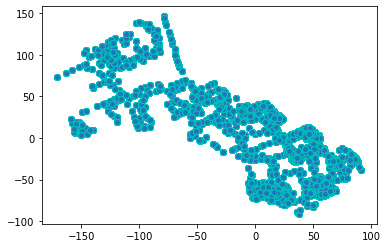

In [3]:
plt.scatter(train_xy['x'],train_xy['y'],edgecolors='c')

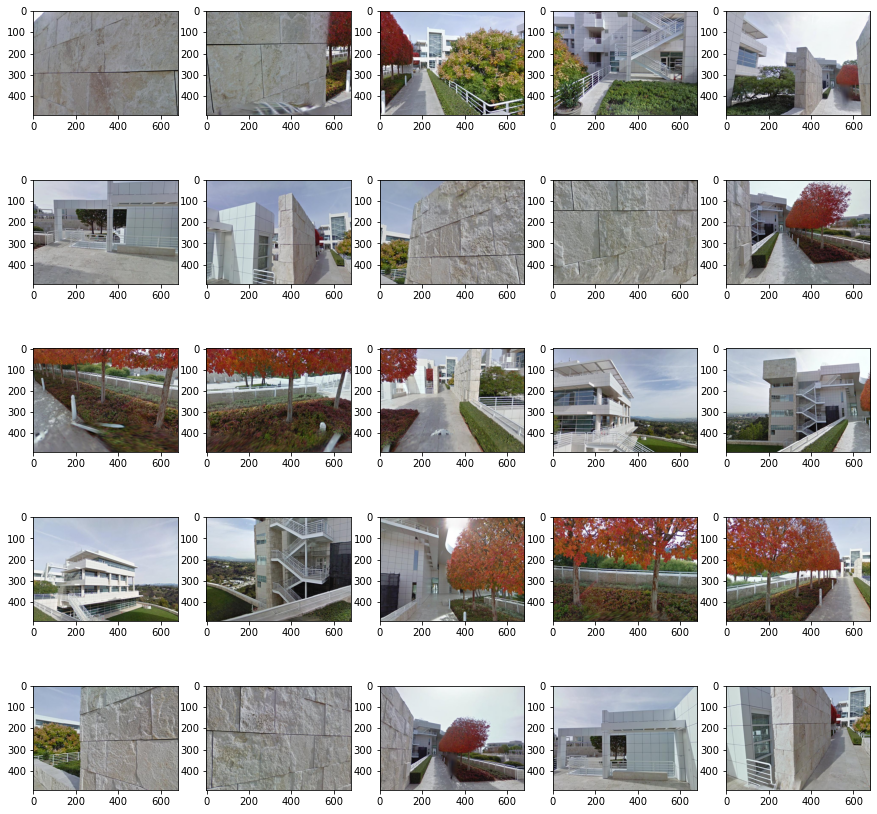

In [4]:
df = train_xy.loc[(train_xy['x']>-81) & (train_xy['y']>70)]

_,ax = plt.subplots(5,5,figsize=(15,15))
for i,idx in enumerate(df.index[:25]):
    ax[int(i/5),i%5].imshow(train_i[idx][:,:,::-1],cmap='gray')

In [6]:
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
for i,img in tqdm.tqdm(enumerate(train_i)):
    _, des = sift.detectAndCompute(img,None)
    f = open(f'./train_kp/train_kp{train_path[i]}.pckl','wb')
    pickle.dump(des,f)
    f.close()

for i,img in tqdm.tqdm(enumerate(test_i)):
    _, des = sift.detectAndCompute(img,None)
    f = open(f'./test_kp/test_kp{test_path[i]}.pckl','wb')
    pickle.dump(des,f)
    f.close()


7500it [11:35, 10.78it/s]
1200it [01:56, 10.31it/s]


In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

best_train = []
second_best_train = []
for test in tqdm.tqdm(test_path):
    f = open(f'./test_kp/test_kp{test_path[i]}.pckl', 'rb')
    des_test = pickle.load(f)
    f.close()
    current_best_train = ''
    current_2nd_best = ''
    current_good = 0
    for train in train_path:
        f = open(f'./train_kp/train_kp{train_path[i]}.pckl', 'rb')
        des_train = pickle.load(f)
        f.close()
        # Matching descriptor using KNN algorithm
        matches = flann.knnMatch(des_test,des_train,k=2)

        # Store all good matches as per Lowe's Ratio test.
        good = len([m for m,n in matches if m.distance < 0.7*n.distance])
        if good > current_good:
            current_2nd_best = current_best_train
            current_good = good
            current_best_train = train
    best_train.append(current_best_train)
    second_best_train.append(current_2nd_best)

  0%|          | 6/1200 [13:12<43:48:26, 132.08s/it]


KeyboardInterrupt: 

In [ ]:
f = open(f'best.pckl','wb')
pickle.dump(best_train,f)
f.close()

f = open(f'2nd_best.pckl','wb')
pickle.dump(second_best_train,f)
f.close()